In [1]:
%matplotlib inline

In [2]:
from KnackpackData import getEncoded,getScores,scoreFunction,n_items,weights,values,max_weight
import matplotlib.pyplot as plt
import numpy as np
import random

## Simulated Annealing

Simulated Annealing (SA) jest stochastycznym algorytmem do znajowania globalnych ekstremówó w dużyc problemach optymalizacyjnych. Wykorzystuje się go bardzo często w problemach optymalizacji wartości dyskretnych.

SA przy każdej iteracji generuje nowy stan, bazujący na obecnym, w którym zmienia losowo jeden bit. Następnie porównywane są wartości nowego i obecnego stanu. Jeżeli wartości nwoego stanu są lepsze od poprzedniego i są akceptowalne (nie przekraczają limitu wagi) są akceptowane. Jeżeli nowo wygenerowany stan jest błędny, poniewaz przykładowo przekracza maksymalną wagę to wciąż może zostać wykorzystany w następnej iteracji w pewnym prawdopodobieństwem. Takie podejście pozwala algorytmowi uciekać z minimów lokalnych.

Do poprawnej pracy algorytmu definiuje się stan początkowy jako pusty plecak oraz parametry wyżarzania, na podsawie których osiągany jest warunek stopu.

In [3]:
# Intial parameters
initial_temp = 1000 # system initial temperature
alpha = 0.999 # temp. change multiplier
frozen_level = 0.1 # default frozen state

initial_state = np.zeros(n_items).astype(bool) # Initial state is empty
temperature = initial_temp
best_state = initial_state
current_state = initial_state

scores_table = [np.sum(values[initial_state])]
best_scores_table = [np.sum(values[initial_state])]
best_value_index = 0

it = 0
# If system equlibrium is ok
while temperature > frozen_level:
    it += 1
    # Generate next state
    next_state = np.copy(current_state)
    idx = np.random.randint(0,n_items) # get random index to flip
    next_state[idx] = 1 - next_state[idx] # flip generated index

    scores_table.append(np.sum(values[next_state]))
    
    # Calculate delta (if next state is better than current)
    delta = np.sum(values[next_state]) - np.sum(values[current_state])

    if delta > 0 and np.sum(weights[next_state]) <= max_weight:
        # If next state is better than current - set this state as current
        current_state = np.copy(next_state)

        # If new state is better than the best - set this state as best
        if np.sum(values[current_state]) > np.sum(values[best_state]):
            best_state = np.copy(current_state)
            best_value_index = it
            best_scores_table.append(np.sum(values[best_state]))
    else:
        # If the new solution is not better, accept it with a probability of e^(-delta/temp)
        acceptance_function = np.exp(-delta / temperature)
        if acceptance_function > random.uniform(0, 1):
            current_state = np.copy(next_state)

    temperature *= alpha
best_value = np.sum(values[best_state])
best_weight = np.sum(weights[best_state])
print("Best value: ",best_value)
print("Best weight: ",best_weight)


Best value:  4.923588170937283
Best weight:  2.9985771114868314


## Visualisations

### Best value in all data

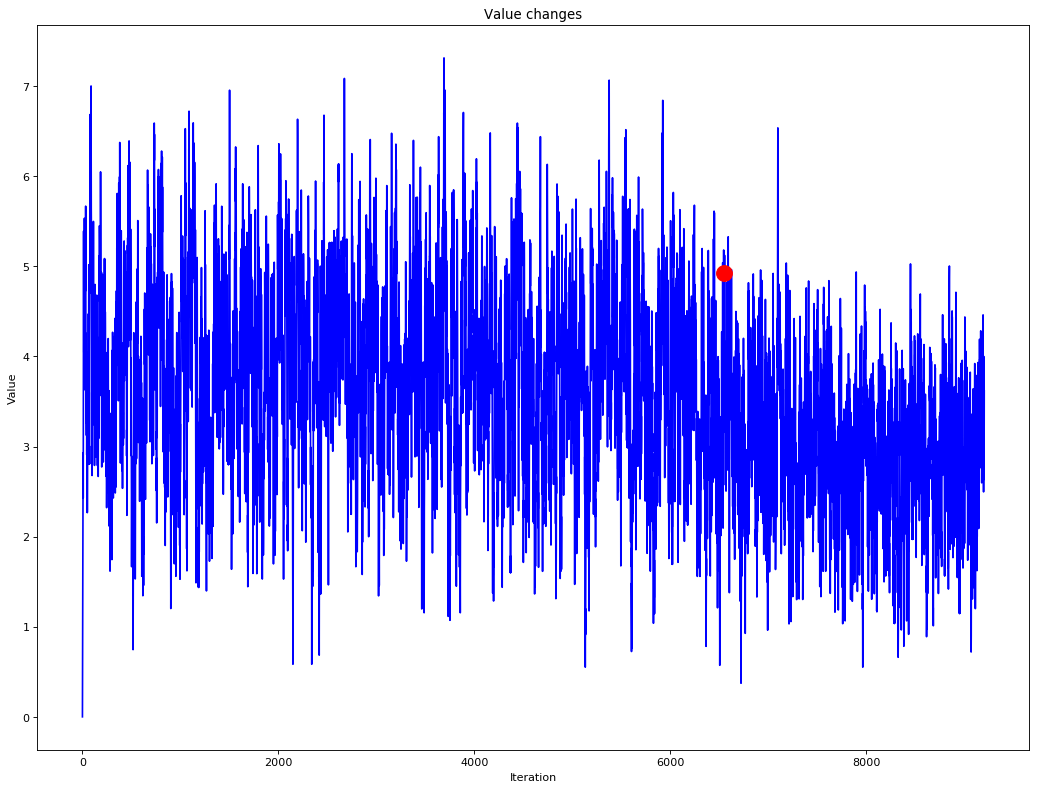

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 12), dpi=80)
plt.scatter(best_value_index, np.array(scores_table)[best_value_index], color="r", s=200, zorder=2)
plt.plot(np.arange(np.array(scores_table).size), np.array(scores_table), color="b", zorder=1)

plt.ylabel('Value')
plt.xlabel('Iteration')
plt.title('Value changes')
plt.show()

### Best values change plot

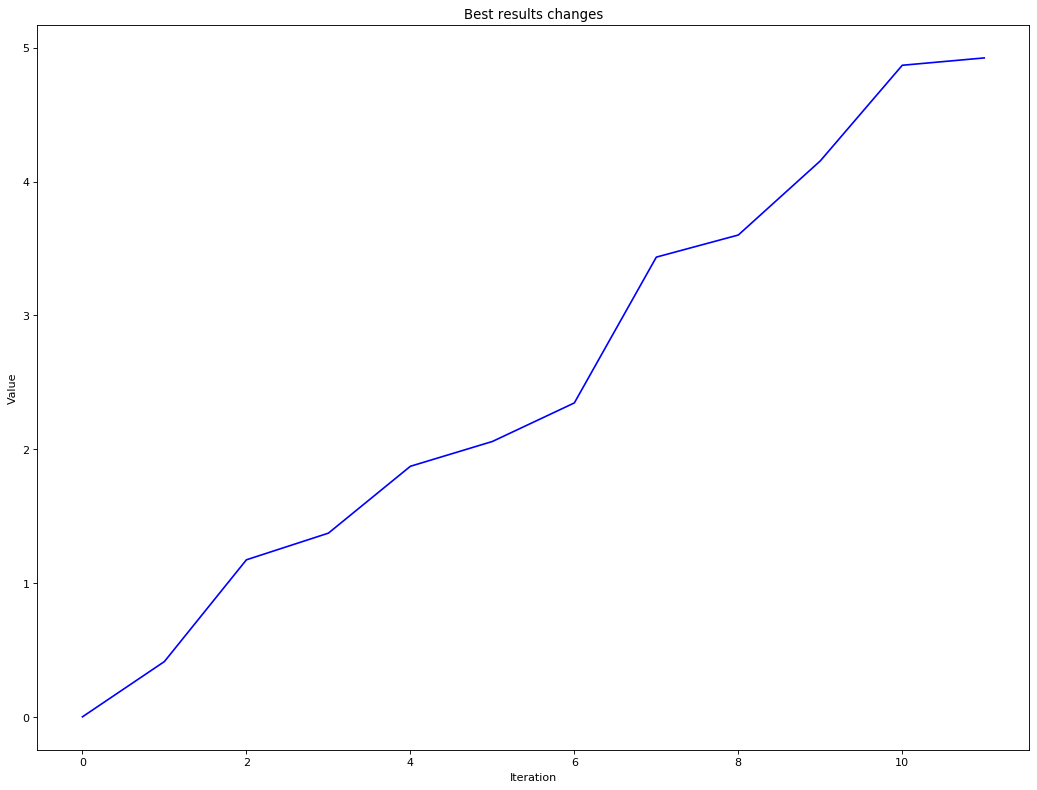

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 12), dpi=80)
plt.plot(np.arange(np.array(best_scores_table).size), np.array(best_scores_table), color="b")
plt.ylabel('Value')
plt.xlabel('Iteration')
plt.title('Best results changes')
plt.show()

## Wnioski

Podana implementacja algorytmu Simulated Annealing z zdanymi parametrami nie znalazła minimum globalnego dla przeszukiwanego zbioru danych, jednakże pokazuje, że algorytm ma potencjał na szukanie minimów globlanych dzięki temu, że potarfi uciekać z minimów lokalnych i lepiej eksplorować cały przeszukiwany obszar. 

Należałoby poszukać jak najlepszych parametrów, które dadzą dobre wyniki. Połączenie z algorytmem genetycznym pozwoli na lepszą eksploatację.